# Machine Learning & Energy 2020/2021 - Mini Project

### Group Number/Kaggle Team Name: xx/xxxxxxxxxxxxx
### Group Members:
- Name, Surname - Matrikelnummer - Kaggle Name
- Name, Surname - Matrikelnummer - Kaggle Name
- Name, Surname - Matrikelnummer - Kaggle Name


### Abstract:
Briefly describe your solution and this notebook in a few sentences.
<br>

*NOTE: Throughout the notebook please explain what you are doing and why you are doing it. Also explain the purpose of the functions and modules you are using. Try to stick to a modular code structure and don't overcrowd this main notebook with code. The structure of this template notebook is only a suggestion, you don't have to stick to this specific structure.*
<br>


### Aditional packages to install 
- ...
- ...

(We will run your notebook in the MLE environment we used in the exercises. If you rely on additional libraries please list them here.)
<br>
<br>
<br>

**PLEASE MAKE SURE THAT YOUR NOTEBOOK AND ASSOCIATED CODE RUNS WITHOUT AN ERROR. ENSURE THAT ALL PATHS ARE RELATIVE TO THE DIRECTORY OF THIS NOTEBOOK.**

## 1. Exploratory data analysis
This section loads, describes, and explores the data and presents interesting findings.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the training and test data

In [17]:
data_train=[]
for i in [1,2,3]:
    data_train.append(pd.read_pickle("data/data_train_"+str(i)+".pkl"))
data_train[0].head()

,u10,v10,u100,v100,power_generation
datetime,,,,,
2012-02-01 00:00:00,-4.530184,1.382200,-5.738897,1.773414,0.175488
2012-02-01 01:00:00,-2.687666,1.932610,-3.242951,2.428160,0.093100
2012-02-01 02:00:00,-1.693595,2.313609,-1.987378,2.862422,0.044108
2012-02-01 03:00:00,-0.985308,2.623123,-1.137379,3.217891,0.036547
2012-02-01 04:00:00,-0.549797,3.040245,-0.638180,3.732756,0.059074


In [18]:
data_test=[]
for i in [1,2,3]:
    data_test.append(pd.read_pickle("data/data_test_"+str(i)+".pkl"))
data_test[0].head()

,u10,v10,u100,v100
datetime,,,,
2013-09-01 00:00:00,1.880972,-1.731423,3.336935,-2.624940
2013-09-01 01:00:00,2.230298,-2.487928,3.249870,-3.380717
2013-09-01 02:00:00,2.843546,-2.487497,3.860654,-3.246824
2013-09-01 03:00:00,3.288904,-2.063180,4.380313,-2.662013
2013-09-01 04:00:00,3.277163,-1.612991,4.342878,-2.065029


Plot the power generation from all three sites for the entire training set.

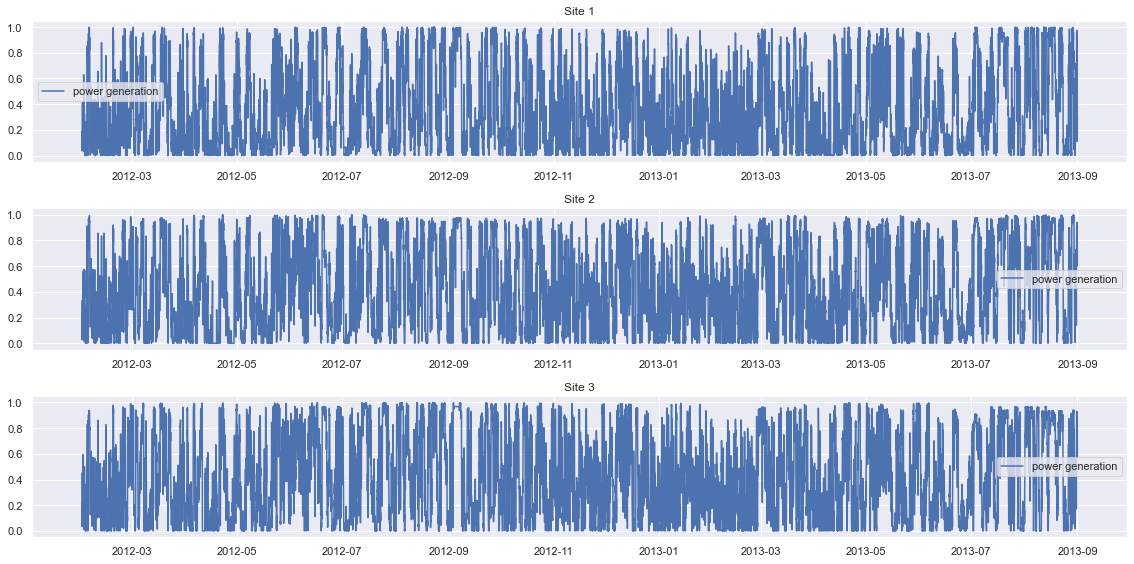

In [19]:
fig, axs=plt.subplots(3,1, figsize=(16,8))
for i in [0,1,2]:
    axs[i].plot(data_train[i]["power_generation"], label="power generation")
    axs[i].set_title(f"Site {i+1}")
    axs[i].legend()
fig.tight_layout()

## 2. Modelling
This section describes the modelling approach, the features you used, and how you set the hyperparmeters for your model(s) etc.

Here are some things to think about:
- What kind of model should I use? Linear regression, KNN, Boosted Trees, Radnom Forests, Neural Networks?
- Do I expect non-linearities in the data?
- How should I encode the wind direction?
- How does the wind speed and wind direction at different heights affect the power generation?
- Does the hour of the day or the time of the year influence the power generation?
- Will information from the other sites improve my rmse?
- Are autoregressive features (e.g. the wind speed in t-1 or t+1) helpful?
- How should I set and evaluate my hyperparameters?
- Should I use different models for the different sites or one model for all three?
- Does it improve the rmse if I average the prediction from different models?

We don't expect you to explore all of these question. Pick a few you think might be worth exploring or think of more things to try out and see where you end up!

### 2.1 Feature engineering

Feature engineering means the creation of useful new inputs from existing inputs.

### a) wind speed and wind direction
In the case of wind power forecasting, two likely important features are the wind speed and the wind direction.
Given the v (the zonal component, i.e. S->N) and u (the meridional component, i.e. W->E) vectors, we can derive the wind speed by $ws = \sqrt{u^2+v^2}$ and the wind direction by $wd=arctan2(u,v)$ (for a more detailed explanation see https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398).

<img src="images/wind_speed_direction.png" width="300">
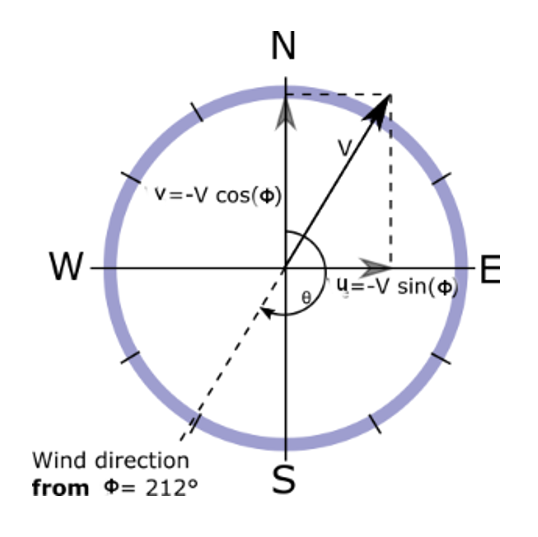

In [20]:
for i in [0,1,2]:
    # wind speed at 100 m 
    data_train[i]["windspeed100"] = np.sqrt(np.square(data_train[i]["u100"]) + np.square(data_train[i]["v100"]))
    data_test[i]["windspeed100"] = np.sqrt(np.square(data_test[i]["u100"]) + np.square(data_test[i]["v100"]))
    data_train[i]["windspeed10"] = np.sqrt(np.square(data_train[i]["u10"]) + np.square(data_train[i]["v10"]))
    data_test[i]["windspeed10"] = np.sqrt(np.square(data_test[i]["u10"]) + np.square(data_test[i]["v10"]))
    # wind angle at 100 m 
    data_train[i]["winddirection100"] = np.arctan2(data_train[i]["u100"], data_train[i]["v100"])*180/np.pi + 180 # i.e. wind from the north equals 0°, easterly wind equals 90° ...
    data_test[i]["winddirection100"] = np.arctan2(data_test[i]["u100"], data_test[i]["v100"])*180/np.pi + 180 # ... southerly wind equals 180°, westerly wind equals 270°
    data_train[i]["winddirection10"] = np.arctan2(data_train[i]["u10"], data_train[i]["v10"])*180/np.pi + 180 # i.e. wind from the north equals 0°, easterly wind equals 90° ...
    data_test[i]["winddirection10"] = np.arctan2(data_test[i]["u10"], data_test[i]["v10"])*180/np.pi + 180 # ... southerly wind equals 180°, westerly wind equals 270°
data_train[0].head()

,u10,v10,u100,v100,power_generation,windspeed100,windspeed10,winddirection100,winddirection10
datetime,,,,,,,,,
2012-02-01 00:00:00,-4.530184,1.382200,-5.738897,1.773414,0.175488,6.006658,4.736353,107.172013,106.967422
2012-02-01 01:00:00,-2.687666,1.932610,-3.242951,2.428160,0.093100,4.051258,3.310367,126.824042,125.718636
2012-02-01 02:00:00,-1.693595,2.313609,-1.987378,2.862422,0.044108,3.484699,2.867237,145.227775,143.795328
2012-02-01 03:00:00,-0.985308,2.623123,-1.137379,3.217891,0.036547,3.412983,2.802072,160.533796,159.412622
2012-02-01 04:00:00,-0.549797,3.040245,-0.638180,3.732756,0.059074,3.786917,3.089557,170.298082,169.749424


### 2.2 Model validation and hyperparamter optimization
This sections describes the training and validation strategy.

NOTE: We already prepared a ``score`` function in the module ``utils`` which calculates the RMSE for your predictions.

## 3. Make a submission
### 3.1 Test set predictions
Make predictions for the test set with your best model(s) and hyperparameters.

We prepared a simple linear regression benchmark model which uses the wind speed at 100m as the only input, i.e. the model is given by $\hat{y}=w_0 + w_1WS$. We also cut off imposible values above $1$ and below $0$.

In [21]:
import models
from models import lin_reg_benchmark
y_pred_lr=[]
for i in [0,1,2]:
    y_pred_lr.append(lin_reg_benchmark(data_train[i], data_test[i]))
y_pred_lr = np.column_stack(y_pred_lr)

In [22]:
# from utils import score
# import numpy as np
# from sklearn.linear_model import LinearRegression
# y_pred_my=[]
# for i in [0,1,2]:
#     mdl = LinearRegression()
#     mdl.fit(mytrain_data_x[i].loc[:,["windspeed100"]].values, mytrain_data_y[i]["power_generation"].values)
#     y_pred_my.append(mdl.predict(mytest_data_x[i].loc[:,["windspeed100"]].values))
#     print(score(np.average(mytrain_data_y[i]["power_generation"].values), mytest_data_y[i].to_numpy()))

### 3.2 Make a submission file
We prepared a function to create a .csv file in the desired format:

In [23]:
import sklearn
from sklearn import model_selection

myTrainDataList = []
myTestDataList = []
myDataTestList = []


for i in [0,1,2]:
    myData_test = data_test[i]
    myTrainData, myTestData = sklearn.model_selection.train_test_split(data_train[i], shuffle=True, test_size=0.1, random_state=42)
    myTrainData.reset_index(inplace = True)
    myTestData.reset_index(inplace = True)
    myData_test.reset_index(inplace=True)
    myTrainData["hour"] = myTrainData.datetime.dt.hour
    myTestData["hour"] = myTestData.datetime.dt.hour
    myTrainData["weekday"] = myTrainData.datetime.dt.weekday
    myTestData["weekday"] = myTestData.datetime.dt.weekday
    myTrainData["month"] = myTrainData.datetime.dt.month
    myTestData["month"] = myTestData.datetime.dt.month
    

    myTrainData = (pd.get_dummies(myTrainData,columns=["hour"]))
    
    myTestData = (pd.get_dummies(myTestData,columns=["hour"]))

    myTrainData = (pd.get_dummies(myTrainData,columns=["weekday"]))
   
    myTestData = (pd.get_dummies(myTestData,columns=["weekday"]))
    
    myTrainData = (pd.get_dummies(myTrainData,columns=["month"]))
    
    myTestData= (pd.get_dummies(myTestData,columns=["month"]))
   

    #myTrainData["datetime"] = (myTrainData["datetime"]-pd.datetime(2012,1,1,0,0,0)).dt.total_seconds()
    #myTestData["datetime"] = (myTestData["datetime"]-pd.datetime(2012,1,1,0,0,0)).dt.total_seconds()
    #myData_test["datetime"] = (myData_test["datetime"]-pd.datetime(2012,1,1,0,0,0)).dt.total_seconds()

    myTestData.drop("datetime",axis = 1,inplace = True)
    myTrainData.drop("datetime",axis = 1, inplace = True)
    myTrainDataList.append(myTrainData)
    myTestDataList.append(myTestData)
    myDataTestList.append(myData_test)



myTrainDataList[0]
#myTestDataList[0]


,u10,v10,u100,v100,power_generation,windspeed100,windspeed10,winddirection100,winddirection10,hour_0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1.293437,0.232801,1.606157,0.349756,0.000000,1.643798,1.314221,257.715073,259.796772,1,...,0,1,0,0,0,0,0,0,0,0
1,3.776170,-0.741559,4.763831,-1.012847,0.104600,4.870313,3.848294,282.003036,281.110290,0,...,0,0,0,0,0,0,1,0,0,0
2,7.210098,-2.980021,11.170523,-4.431058,0.994171,12.017274,7.801669,291.636947,292.455900,0,...,0,0,0,1,0,0,0,0,0,0
3,-1.143812,2.481207,-1.684996,4.737387,0.021739,5.028126,2.732159,160.420517,155.250762,0,...,0,0,0,0,0,0,0,1,0,0
4,5.901961,-1.784875,9.405119,-2.650157,0.993541,9.771366,6.165949,285.736677,286.826399,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12479,1.118418,-7.407600,1.850235,-11.882859,0.948015,12.026042,7.491555,351.149756,351.414187,0,...,0,0,0,0,0,0,1,0,0,0
12480,5.353405,-2.762950,7.121290,-3.688463,0.303560,8.019822,6.024353,297.381841,297.298746,0,...,0,0,0,0,0,1,0,0,0,0
12481,4.883099,4.592455,7.214146,7.214694,0.699118,10.202731,6.703380,224.997825,226.756887,0,...,0,0,0,0,0,0,1,0,0,0
12482,-4.045331,-0.582300,-7.830136,-1.472154,0.729836,7.967325,4.087025,79.352048,81.808895,0,...,1,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn import preprocessing
myTrainDataListX = []
myTrainDataListY = []
myTestDataListX = []
myTestDataListY = []
for i in [0,1,2]:
    dataTrainX = pd.DataFrame.drop(myTrainDataList[i],labels ="power_generation",axis = 1)
    myTrainDataListY.append(pd.DataFrame(myTrainDataList[i]["power_generation"]))
    dataTestX = pd.DataFrame.drop(myTestDataList[i],labels ="power_generation",axis = 1)
    myTestDataListY.append(pd.DataFrame(myTestDataList[i]["power_generation"]))
    
    normalized_TrainDataX=(dataTrainX-dataTrainX.mean())/dataTrainX.std()
    normalized_TestDataX=(dataTestX-dataTestX.mean())/dataTestX.std()
    normalized_TrainDataXMinMax=(dataTrainX-dataTrainX.min())/(dataTrainX.max()-dataTrainX.min())
    normalized_TestDataXMinMax=(dataTestX-dataTestX.min())/(dataTestX.max()-dataTestX.min())


    myTrainDataListX.append(normalized_TrainDataX)
    myTestDataListX.append(normalized_TestDataX)

myTrainDataListX[0]
#myTrainDataListY[0]
#myTestDataListX[0]
#myTestDataListY[0]

,u10,v10,u100,v100,windspeed100,windspeed10,winddirection100,winddirection10,hour_0,hour_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.145241,0.061550,0.086054,0.086164,-1.787425,-1.451312,0.701547,0.760117,4.735012,-0.20616,...,-0.346893,2.941831,-0.347907,-0.339750,-0.345443,-0.346313,-0.236061,-0.236817,-0.235493,-0.238322
1,0.861821,-0.280967,0.677824,-0.209985,-0.619582,-0.141015,0.943103,0.973590,-0.211176,-0.20616,...,-0.346893,-0.339897,-0.347907,-0.339750,-0.345443,-0.346313,4.235849,-0.236817,-0.235493,-0.238322
2,1.852940,-1.067852,1.878482,-0.952901,1.967275,1.903162,1.038917,1.087226,-0.211176,-0.20616,...,-0.346893,-0.339897,-0.347907,2.943101,-0.345443,-0.346313,-0.236061,-0.236817,-0.235493,-0.238322
3,-0.558211,0.851931,-0.530731,1.039773,-0.562461,-0.718137,-0.266098,-0.287001,-0.211176,-0.20616,...,-0.346893,-0.339897,-0.347907,-0.339750,-0.345443,-0.346313,-0.236061,4.222338,-0.235493,-0.238322
4,1.475378,-0.647723,1.547633,-0.565839,1.154364,1.057378,0.980236,1.030842,-0.211176,-0.20616,...,-0.346893,-0.339897,-0.347907,-0.339750,-0.345443,2.887327,-0.236061,-0.236817,-0.235493,-0.238322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12479,0.094726,-2.624278,0.131796,-2.572478,1.970449,1.742812,1.630803,1.677745,-0.211176,-0.20616,...,-0.346893,-0.339897,-0.347907,-0.339750,-0.345443,-0.346313,4.235849,-0.236817,-0.235493,-0.238322
12480,1.317051,-0.991546,1.119628,-0.791505,0.520389,0.984163,1.096053,1.135732,-0.211176,-0.20616,...,-0.346893,-0.339897,-0.347907,-0.339750,-0.345443,2.887327,-0.236061,-0.236817,-0.235493,-0.238322
12481,1.181309,1.594097,1.137030,1.578192,1.310497,1.335268,0.376157,0.429194,-0.211176,-0.20616,...,-0.346893,-0.339897,-0.347907,-0.339750,-0.345443,-0.346313,4.235849,-0.236817,-0.235493,-0.238322
12482,-1.395663,-0.224983,-1.682373,-0.309811,0.501388,-0.017574,-1.072365,-1.022585,-0.211176,-0.20616,...,2.882500,-0.339897,-0.347907,-0.339750,-0.345443,-0.346313,-0.236061,-0.236817,-0.235493,-0.238322


In [26]:
# #from sklearn import svm
# from utils import score
# from sklearn.neighbors import KNeighborsRegressor as KNNR
# #regr = svm.SVR()
# #for j in range(len(myTestDataListX)):
#     #regr.fit(myTrainDataListX[j].to_numpy(),myTrainDataListY[j].to_numpy())
#     #pred = regr.predict(myTestDataListX[j].to_numpy())
#     #print(score(pred,myTestDataListY[j].to_numpy()))

# y_pred_knn = []

# regr = KNNR(2, weights='distance')
# for j in range(len(myTrainDataListX)):
#     print(myTrainDataListX[j].shape)
#     print(myDataTestList[j].shape)
#     regr.fit(myTrainDataListX[j].to_numpy(), myTrainDataListY[j].to_numpy())
#     #print(myTrainDataListX[j].to_numpy())
#     pred = regr.predict(myDataTestList[j].to_numpy())
#     a = regr.predict(myDataTestList[j].to_numpy())
#     y_pred_knn.append(a)

#     #print(float(score(pred, myTestDataListY[j].to_numpy())))

    
# y_pred_knn = np.column_stack(y_pred_knn)

(12484, 51)
(2904, 9)


TypeError: float() argument must be a string or a number, not 'Timestamp'

In [81]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn import linear_model
import numpy as np
from utils import score
model = make_pipeline(PolynomialFeatures(2,include_bias=True,interaction_only=False), Ridge(alpha=0.5))
#model = make_pipeline(PolynomialFeatures(2,include_bias=True,interaction_only=False),LinearRegression(fit_intercept=True)) 
 
y_pred_ridge = []

for j in range(len(myTrainDataListX)):
    #model.fit(myTrainDataListX[j].loc[:,["windspeed10","winddirection10"]], myTrainDataListY[j])
    #predi = model.predict(myTestDataListX[j].loc[:,["windspeed10","winddirection10"]])
    model.fit(myTrainDataListX[j], myTrainDataListY[j])
    predi = model.predict(myTestDataListX[j])
    #predi = predi.to_numpy()
    y_pred_ridge.append(predi)
    #print(float(score(predi, myTestDataListY[j].to_numpy())))
  

In [82]:
from utils import make_submission_file
make_submission_file(y_pred_ridge)

ValueError: 
predictions has to be either pandas DataFrame or numpy array.

You should find your predictions as a .csv file in the folder ``/submissions``.

You can make a submission by dragging and dropping the created file at https://www.kaggle.com/c/mle2021/submit.

To be able to make a submission you first need a Kaggle account and register for the competition using this link: https://www.kaggle.com/t/c47a776efcae4ea3be9464a42f63ef64.

Happy forecasting!